#### 在ER和SF网络中研究同步的路径
ref : J. Gómez-Gardeñes, et al. Paths to synchronization on complex networks, Phys. Rev. Lett. 98, 34101 (2007).

model: Kuramoto model

network: scale-free network, ER network 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
import random
import networkx as nx
from scipy.sparse import coo_matrix
import scipy.sparse as sp
from joblib import Parallel, delayed
from tqdm import tqdm

In [2]:
seed = 0
random.seed(seed)
np.random.seed(seed)

##### 模型算法

In [3]:
# Kuramoto 模型
def kuramoto(vars, t, omega, c, pre_ids, post_ids):
    """
    Kuramoto 模型的微分方程。
    args:
        vars: 相位
        t: 当前时间
        omega: 自然频率
        c: 耦合强度
    """
    currents = c * np.sin(vars[pre_ids]- vars[post_ids])

    num_nodes = len(vars)
    
    I_couple = np.bincount(post_ids, weights=currents, minlength=num_nodes)

    dvars_dt = omega + I_couple

    return dvars_dt

def RK4(fun, x0, t, dt, *args):
    """
    使用 Runge-Kutta 方法计算一个时间步后系统的状态。
    args:
        fun: 微分方程
        x0: 上一个时间单位的状态变量
        t: 运行时间
        dt: 时间步长
    :return:
        x0 (numpy.ndarray): 下一个时间单位的状态变量
    """
    k1 = fun(x0, t, *args)
    k2 = fun(x0 + (dt / 2.) * k1, t + (dt / 2.), *args)
    k3 = fun(x0 + (dt / 2.) * k2, t + (dt / 2.), *args)
    k4 = fun(x0 + dt * k3, t + dt, *args)

    x0 += (dt / 6.) * (k1 + 2 * k2 + 2 * k3 + k4)

    return x0

##### 统计量

In [4]:
def order_parameter(vars):
    """
    计算系统的序参量。
    args:
        vars: 相位
    return:
        r (float): 序参量
    """
    N = len(vars)
    r = np.abs(np.sum(np.exp(1j * vars)) / N)
    return r


In [5]:
# 运行
def net(c, n, A):
    post_ids = A.row
    pre_ids = A.col

    # 自然频率
    # omega = np.random.uniform(-np.pi, np.pi, n)/10
    omega = np.random.uniform(-.45, .45, n)

    # 初始相位
    # vars = np.random.uniform(-np.pi, np.pi, n)
    vars = np.zeros(n)  # 初始相位为0

    N_links = A.sum()

    dt = 0.05

    t = 0.
    
    # 初始化
    # for i in range(1000_00):
    #     RK4(kuramoto, vars, t, dt, omega, c, pre_ids, post_ids)
    #     t += dt

    r = 0.
    complex_exp = 0.
    cal_n = 1000_00
    for i in range(cal_n):
        RK4(kuramoto, vars, t, dt, omega, c, pre_ids, post_ids)
        t += dt

        r += order_parameter(vars)/cal_n
        
        vars_diff = vars[post_ids] - vars[pre_ids]
        
        complex_exp += np.exp(1j * vars_diff) / cal_n

    r_link = np.abs(complex_exp).sum() / N_links

    return r, r_link

In [6]:
n = 1000  # 节点数

topology="ER"
# 拓扑结构
if topology == "ER":
    m = 6 
    G = nx.gnm_random_graph(n, int(m*n/2))

elif topology == "SF":
    k = 6
    G_init = nx.complete_graph(k+1)
    G = nx.barabasi_albert_graph(n, int(k/2), initial_graph=G_init)

A = nx.adjacency_matrix(G).tocoo() # 邻接矩阵(稀疏)

In [7]:
# c_= 0.1
# net(c_, n, A)

In [8]:
c_list = np.linspace(0.001, 0.2, 20)  # 耦合强度列表

In [9]:
results1 = Parallel(n_jobs=20)(delayed(net)(c, n, A) for c in tqdm(c_list))

100%|██████████| 20/20 [00:00<00:00, 251.90it/s]


In [10]:
k = 6
G_init = nx.complete_graph(k+1)
G = nx.barabasi_albert_graph(n, int(k/2), initial_graph=G_init)

A = nx.adjacency_matrix(G).tocoo() # 邻接矩阵(稀疏)

In [11]:
results2 = Parallel(n_jobs=20)(delayed(net)(c, n, A) for c in tqdm(c_list))

100%|██████████| 20/20 [00:00<00:00, 19840.61it/s]


In [12]:
results11 = np.asarray(results1).T
results22 = np.asarray(results2).T

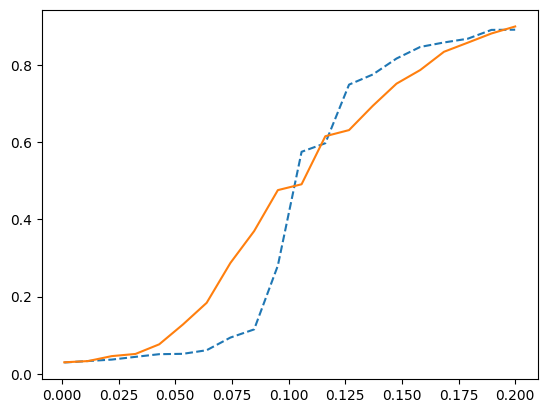

In [13]:
plt.plot(c_list, results11[0], linestyle='--')
plt.plot(c_list, results22[0])
plt.show()

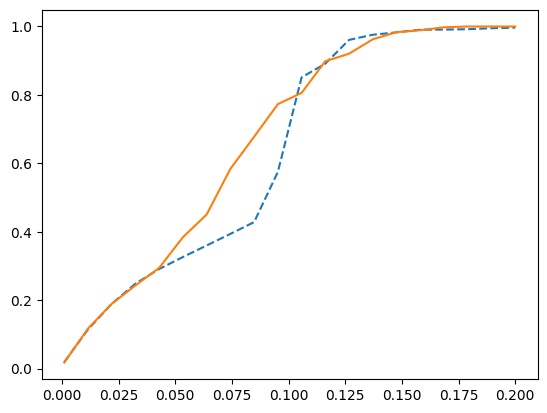

In [14]:
plt.plot(c_list, results11[1], linestyle='--')
plt.plot(c_list, results22[1])
plt.show()